In [1]:
import ginsim
import biolqm
from colomoto_jupyter import tabulate
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

try:
    import cobra
except ImportError:
    import sys
    !{sys.executable} -m pip install cobra
    import cobra

cmp = sns.diverging_palette(0, 255, as_cmap=True)

This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-10-01`

# 1. Loading the two models of interest

- The CaSQ-generated CAF-specific boolean model;
- MitoCore constraint-based model of human metabolism.

## 1. 1. Load the generic CAF-model

In [2]:
CAF_model = biolqm.load("CAF-model.sbml")

The sanitize function is used to generate human-friendly node IDs and rescale the layout to improve the model's readability.


*Note: this cell may take a few minutes to run.*

In [3]:
CAF_model = biolqm.sanitize(CAF_model)

layout = CAF_model.getLayout()
layout.scale(0.4)

lrg = biolqm.to_ginsim(CAF_model)

ginsim.show(lrg)

## 1.2. Load MitoCore 

In [4]:
import logging
cobra.io.sbml.LOGGER.setLevel(logging.ERROR)

MitoCore = cobra.io.read_sbml_model('mitocore_v1.01.xml')

# 2. Value propagation

We show that the **input conditions** (here, based on literature) strongly control the whole network.

In [5]:
inits = pd.read_csv("Breast_CAF_initial_conditions.tsv", sep="\t", index_col=0)
dic_inits = inits.to_dict()

Definition of some helper functions and color mapping rules to perform value propagation and visualize the result.

In [6]:
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"

def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)

def restrict_model(model, **dict_vals):
    pattern = dash_pattern(model, dict_vals)
    return biolqm.restrict(model, pattern)

def fill_fixed(data, names, functions, mddman):
    all_values = [f for f in functions]
    for comp, func in zip(names, functions):
        if mddman.isleaf(func): data[comp] = func
        else: data[comp] = -1
    

def get_fixed_pattern(all_names, model, as_dict=False):
    # Build a container for the results
    pattern = {key: 100 for key in all_names}
    
    # Model manager and core components
    mddman = model.getMDDManager()
    core_components = [node.getNodeID() for node in model.getComponents()]
    extra_components = [node.getNodeID() for node in model.getExtraComponents()]
    
    # 1/ Non-extra values: if the model was not reduced, core components may also contain fixed values
    fill_fixed(pattern, core_components, model.getLogicalFunctions(), mddman)
    
    # 2/ Extra values : only available after reduction/percolation
    # Functions of each component
    fill_fixed(pattern, extra_components, model.getExtraLogicalFunctions(), mddman)

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte)

def get_fixed(gs_model, restricted_model, as_dict=False):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    return get_fixed_pattern(name_components, restricted_model, as_dict)

def show_fixed(gs_model, styler, fixed_pattern, save=None):
    styler.setState(fixed_pattern.values.tobytes())
    return ginsim.show(gs_model, style=styler, save=save)


# Define color mapping rules
styler_fixed = ginsim.lrg_style(lrg)
styler_fixed.mapState2Color(0, 255, 255, 255)
styler_fixed.mapState2Color(1, 100, 100, 255)
styler_fixed.mapState2Color(-1, 255, 100, 100)

In [7]:
data = []

for init_name, values in dic_inits.items():
    lqm_model_restricted = restrict_model(CAF_model, **values)
    data.append( get_fixed(lrg, lqm_model_restricted) )
    
df = pd.concat(data, axis=1, keys=[name for name in dic_inits])

In [8]:
df.to_csv("Breast_CAF_model_value_propagation.csv")

The result of value propagation can be visualized in the following heatmap where each line represents a component of the system and the column represent the input condition. 
    
- A **white cell** denotes that the corresponding component is **fixed at 0** by value propagation in this input condition;
- A **blue cell** denotes that the corresponding component is **fixed at 1** by value propagation in this input condition;
- A **red cells** denote components **which are not fixed** by value propagation in this input condition.

<AxesSubplot:>

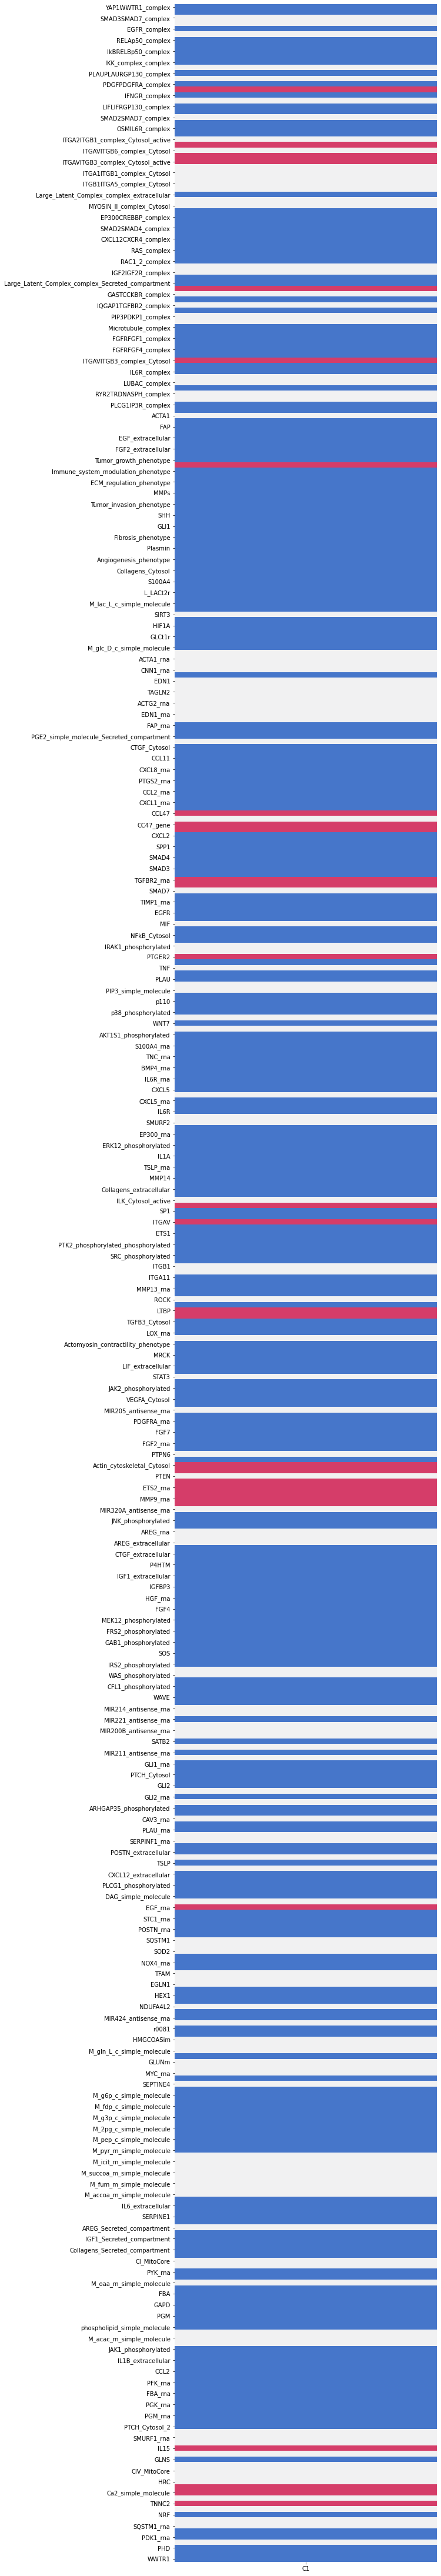

In [9]:
plt.figure(figsize=(8,80))

sns.heatmap(df, center=0, cmap=cmp, cbar=False)

Propagated inputs for a specific input condition can also be mapped on the regulatory graph using the same color code.

In [10]:
fixed = data[0]

show_fixed(lrg, styler_fixed, fixed, save="Breast_CAF_model_value_propagation_visualization.svg")

/notebook/persistent/Sahar/CAF_hybrid_model/Breast_CAF_model_value_propagation_visualization.svg

# 3. Identification of breast CAF-model's trap-spaces 

## 3.1. Using the output of value propagation as a new set of initial conditions

The biolqm.perturbation function enables the construction of a variant of the model, where the logical function of one or several components has been modified. A textual parameter describes the modification:

    component%0 defines a knockout of a component
    component%1 defines an ectopic expression
    
To perturbate the model, the output dataframe of value propagation is transformed as a list of perturbations in the form **'component1%value component2%value ... componentN%value'**.

In [11]:
df = df[df.C1 >= 0]
df["modifs"]= df.index.map(str) + "%" + df["C1"].map(str) 
modifications = pd.DataFrame(df["modifs"]).copy()
modifications = modifications.reset_index(drop=True)
pert = modifications["modifs"].tolist()
perturbations = " ".join(pert)

In [12]:
CAF_model_perturbated = biolqm.perturbation(CAF_model, perturbations)

## 3.2. Identification of CAF-model's regulatory trap-spaces

A trap-space, also called stable motif or called symbolic steady state, is a partially assigned state such that all possible successors of all states which belong to the motif also belong to the motif. Like stable states, these stable motifs can be identified efficiently using constraint-solving methods.

In [13]:
trapspaces = biolqm.trapspace(CAF_model_perturbated)
trapspaces_df = pd.DataFrame(trapspaces)

trapspaces_df.columns = (trapspaces_df.columns.str.replace("_complex", "")
                         .str.replace('_phosphorylated','')
                         .str.replace("_Cytosol","")
                         .str.replace('_simple_molecule', '')
                         .str.replace('_active', '')
                         .str.replace('M_', '')
                         .str.replace('_rna','')
                         .str.replace('_antisense','')
                         .str.replace('_Nucleus','')
                         .str.replace('_empty','')
                         .str.replace('_extracellular','')
                         .str.replace('_Secreted_compartment', '')
                         .str.replace('_space','')
                         .str.replace('_Mitochondrion_outter_mb','')
                         .str.replace('_Mitochondrion_inner_mb',''))

trapspaces_df

,YAP1WWTR1,Arp23,SMAD3SMAD7,IL1R,EGFR,TNFTNFR1,RELAp50,RELAp50NFKBIA,IkBRELBp50,IkBkGp50,IKK,TNFTNFR2,PLAUPLAURGP130,MIFCD74,PDGFPDGFRA,TGFBTGFBR12,IFNGR,mTORC1,LIFLIFRGP130,SMAD3SMAD4,SMAD2SMAD7,Myosin_Phosphatase,OSMIL6R,ITGA11ITGB1,ITGA2ITGB1,ITGAVITGB5,ITGAVITGB6,ITGAVITGB5,ITGAVITGB3,ITGA1ITGB1,ITGA1ITGB1,ITGB1ITGA5,ITGB1ITGA5,ITGAVITGB6,Large_Latent_Complex,MYOSIN_II,MYOSIN_II,EP300STAT1,EP300CREBBP,LIFRGP130,SMAD2SMAD4,PLAURGP130,CXCL12CXCR4,CDC42,RAS,HGFMET,RAC1_2,RHOA,IGF2IGF2R,SMOPTCH,Large_Latent_Complex,PGE2PTGER2,GASTCCKBR,PKCDAG,IQGAP1TGFBR2,NADPH_oxidase_4,PIP3PDKP1,ITGA2ITGB1,Microtubule,FGFRFGF2,FGFRFGF1,FGFRFGF3,FGFRFGF4,ITGA11ITGB1,ITGAVITGB3,IL6IL6R,IL6R,IL1R_2,LUBAC,MAP3K7TAB,RYR2TRDNASPH,RYR2TRDNASPHHRCCASQ2,PLCG1IP3R,Markers_of_fibroblast_activation_phenotype,ACTA1,TNC,FAP,TGFB3,EGF,PDGF,FGF2,Growth_factors_production_phenotype,Tumor_growth_phenotype,EGF,Immune_system_modulation_phenotype,Cytokine_production_phenotype,ECregulation_phenotype,FN,MMPs,Reactive_stroma_phenotype,Tumor_invasion_phenotype,LOX,SHH,IHH,GLI1,SERPINE1,Fibrosis_phenotype,PLG,Plasmin,Matrix_degradation_phenotype,Angiogenesis_phenotype,IL6,Collagens,Fibroblast_markers_phenotype,S100A4,Formation_of_basement_membrane_phenotype,L_LACt2r,lac_L_e,lac_L_c,L_LACt2r,SIRT3,ROS_production_phenotype,HIF1A,HIF1A,GLCt1r,glc_D_e,glc_D_c,LPA,ACTA1,CNN1,CNN1,FN,EDN1,MYL12A,TAGLN2,ACTG2,ACTG2,MYL12A,EDN1,TAGLN2,FAP,PTGS2,PGE2,PPBP,CTGF,CXCL8,CCL11,CCL11,CXCL8,IL6,PTGS2,LGALS1,CCL2,Collagens,CXCL1,CXCL1,CCL47,CCL8,CC47_gene,CCL47,CXCL2,CXCL2,SPP1,SMAD2,SMAD4,SMAD2,SMAD3,TGFB3,TGFBR2,TGFBR2,SMAD7,SMAD3,TIMP1,TIMP1,EGFR,PDGFRA,MIF,IkB,NFkB,NFkB,IRAK1,TRAF6,PTGER2,PGE2,TNF,LDH_L,PLAU,PIP2,PIP3,ARHGEF7,p110,Migration_into_the_tumor_phenotype,p38,STAT3,WNT7,CAV3,AKT1S1,CCDC88A,S100A4,MIR21,TNC,CXCL12,BMP4,BMP4,IL6R,gp130,CXCL5,PPBP,CXCL5,gp130,IL6R,SMURF1,SMURF2,EP300,EP300,EGR1,ERK12,Fibroblast_proliferation_phenotype,IL1A,IL1B,TSLP,MMP2,MMP14,MMP14,Collagens,ILK,ILK,TGFBR2_ubiquitinated,SP1,ITGB5,ITGAV,ITGB5,ETS1,FN,PTK2,PTK2,SRC,ITGB5_ubiquitinated,ITGB1,ITGB1,ITGA11,ITGA11,MMP13,MMP13,ROCK,VTN,LTBP,LAP,TGFB3,IGF2,LOX,MYLK,Actomyosin_contractility_phenotype,OSM,MRCK,LIF,LIF,IFNG,STAT3,IL11,JAK2,proPLAU,VEGFA,VEGFA,MIR205,SPP1,PDGFRA,PDGF,FGF7,FGF7,FGF2,HGF,PTPN6,STAT1,Actin_cytoskeletal,Actin_cytoskeletal_2,PTEN,ETS2,ETS2,ETS2,MMP9,MMP9,MIR320A,EMILIN1,JNK,EGFR,AREG,AREG,AREG,IGF2,CTGF,CTGF,P4HTM,P4HTrna,IGF1,IGF1,IGFBP3,IGFBP4,HGF,FGF1,FGF4,FGF3,MEK12,SHC1,FRS2,PTPN11,GAB1,GRB2,SOS,RAF,IRS2,IGF1R,WAS,LIMK1,CFL1,CFL1,WAVE,MIR155,MIR214,MIR31,MIR221,MIR141,MIR200B,MIR101,SATB2,IGF2R,MIR211,Negative_regulators_of_CAFs_phenotype,GLI1,PTCH2,PTCH,SMOX,GLI2,GLI3,GLI2,GLI3,ARHGAP35,Hypoxia_phenotype,CAV3,proPLAU,PLAU,SERPINF1,SERPINF1,PDGF,POSTN,CCL8,TSLP,JUND,CXCL12,GAST,PLCG1,PI45P2,DAG,IQGAP1,EGF,STC1,STC1,POSTN,POSTN,HSF1,SQSTM1,MYC,SOD2,NOX4,NOX4,PYK,TFAM,ICDHxm,EGLN1,GLCt1r,HEX1,HEX1,NDUFA4L2,NDUFA4L2_,MIR424,glu_L_m,r0081,GPT2,HMGCOASim,gln_L_m,gln_L_c,VEGFA,GLUNm,GLS,MYC,CDC42EP3,SEPTINE4,CXCL12,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,3pg_c,2pg_c,pyr_c,pep_c,13dpg_c,pyr_m,cit_m,icit_m,akg_m_mitochondria,succoa_m,succ_m,fum_m,mal_L_m,accoa_m,LIF,IL6,IL6,SERPINE1,FGF2,AREG,IGF2,IGF1,HGF,Collagens,FN,CI_MitoCore,akg_m,PYK,LDH_L,oaa_m,PGI,FBA,TPI,GAPD,PGK,PGM,ENO,phospholipid,hmgcoa_m,acac_m,bhb_m,JAK1,IL1B,IL1B,IL11,CCL2,PFK,PFK,PGI,FBA,TPI,PGK,GAPD,PGrna,ENO,PTCH_2,SMURF2,SMURF1,IL12,IL15,IL18,GLNS,PDHm,CIV_MitoCore,CASQ2,HRC,Ca2,Ca2,CALML3,TNNC2,SIRT3,NRF,TFArna,SQSTM1,PDK1,PDK1,CIII_MitoCore,PHD,YAP1,WWTR1
0,1,1,0,0,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,

In [14]:
trapspaces_df.to_csv("complete_breast_CAF_model_trapspaces.csv")

# 4. Projection of regulatory trap-spaces on metabolic compounds

## 4.1. Extraction of metabolic components 

To extract common enzymes and metabolites between MitoCore and the CAF-model we generate:

- The list of enzymes in MitoCore;
- The list of metabolites in MitoCore;
- The list of compounds (both enzymes and metabolites) in the breast CAF-model.

These list are used to compare both models and automatically extract common components (with their class: "metabolic enzyme" or "metabolite"). We exclude common metabolic intermediates.

In [15]:
CAF_model_components = trapspaces_df.columns.values

MitoCore_Enzymes = [r.id for r in MitoCore.reactions]

MitoCore_Metabolites = [m.id for m in MitoCore.metabolites]

### 4.1.1. Extracting common metabolic enzymes

In [16]:
common_enzymes = list((set(CAF_model_components).intersection(MitoCore_Enzymes)))

### 4.1.2. Extracting common metabolites

We limit the metabolite matching by excluding a list of predefined compounds which are considered by MitoCore as metabolites but are common metabolic intermediates.

In [17]:
intermediates = ["atp_c", "adp_c", "adn_c", "adp_m", "amp_c", "amp_m", "atp_m", "cdp_m", "cmp_c", "co_c", "co_e",
                 "co2_c", "co2_e", "co2_m", "coa_c", "coa_m", "ctp_c", "fe2_c", "fe2_e", "fe2_m", "ficytC_c",
                 "ficytC_e", "ficytC_m", "gdp_c", "gdp_m", "gtp_c", "gtp_m", "h_c", "h_e", "h_m", "h2o_c", "h2o_m",
                 "h2o2_c"," h2o2_m", "hco3_c", "hco3_e", "hco3_m", "nad_c", "nad_e", "nad_m", "nadh_c", "nadh_e",
                 "nadh_m", "nadp_c", "nadp_m", "nadph_c", "nadph_m", "no_c", "no_e", "o2_c", "o2_e", "o2_m", "o2s_m",
                 "pheme_c", "pheme_m", "pi_c", "pi_e", "pi_m", "q10_m", "q10h2_m"]

In [18]:
common_metabolites = list(set(CAF_model_components).intersection(MitoCore_Metabolites)-set(intermediates))

## 4.2. Projecting metabolic components' regulatory trap-spaces

### 4.2.1. Projecting metabolic enzymes' regulatory trap-spaces

In [19]:
trapspaces_metabolic_enzymes = trapspaces_df[common_enzymes]

### 4.2.2. Projecting metabolites' regulatory trap-spaces

In [20]:
trapspaces_metabolites = trapspaces_df[common_metabolites]

# 5. Flux Balance Analysis (FBA)

Definition of an **ATP_total** objective function representing maximum cellular ATP production through glycolysis and oxidative phosphorylation:

In [21]:
MitoCore.objective = ["PYK", "PGK", "CV_MitoCore"]

## 5.1. FBA n°1: Control

In [22]:
ATP_total_CTL = MitoCore.optimize().objective_value

In [23]:
MitoCore.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
acac_e,EX_acac_e,0.114,4,2.49%
ala_L_e,EX_ala_L_e,0.01,3,0.16%
arg_L_e,EX_arg_L_e,0.007,6,0.23%
asn_L_e,EX_asn_L_e,0.01,4,0.22%
asp_L_e,EX_asp_L_e,0.154,4,3.36%
bhb_e,EX_bhb_e,0.048,4,1.05%
but_e,EX_but_e,0.006,4,0.13%
cyan_e,EX_cyan_e,0.001,1,0.01%
cys_L_e,EX_cys_L_e,0.001,3,0.02%
glc_D_e,EX_glc_D_e,0.9,6,29.48%


In [24]:
solution = MitoCore.optimize()

ATP_glycolysis_CTL = (solution.fluxes['PYK'] + solution.fluxes['PGK'])/(solution.objective_value)

print("The proportion of global ATP production through glycolysis in control conditions is", round(ATP_glycolysis_CTL, 4), ".")

The proportion of global ATP production through glycolysis in control conditions is 0.0405 .


In [25]:
pd.DataFrame(MitoCore.optimize().fluxes).to_csv('FBA_CTL_obj_ATP.csv')

## 5.2. FBA n°2: Breast CAF-specific

### 5.2.1. Constraining metabolic fluxes with regulatory trap-spaces 

#### 5.2.1.1. Constraining metabolic fluxes with maximum metabolic enzymes' regulatory trap-spaces equal to 0

In [26]:
trapspaces_metabolic_enzymes_zero = trapspaces_metabolic_enzymes.loc[:,(trapspaces_metabolic_enzymes.max(axis=0)) == 0]
enzymes_to_zero = trapspaces_metabolic_enzymes_zero.columns.values.tolist()

enzymes_to_zero

['HMGCOASim',
 'CIV_MitoCore',
 'PDHm',
 'GLUNm',
 'CIII_MitoCore',
 'ICDHxm',
 'CI_MitoCore']

Setting the constraints:

In [27]:
for i in enzymes_to_zero:
    MitoCore.reactions.get_by_id(i).lower_bound = 0
    MitoCore.reactions.get_by_id(i).upper_bound = 0

#### 5.2.1.2. Constraining metabolic fluxes with maximal metabolites' regulatory trap-spaces eual to 0

In [28]:
trapspaces_metabolites_zero = trapspaces_metabolites.loc[:,(trapspaces_metabolites.max(axis=0)) == 0]
metabolites_to_zero = trapspaces_metabolites_zero.columns.values.tolist()

metabolites_to_zero

['succoa_m',
 'glu_L_m',
 'hmgcoa_m',
 'acac_m',
 'bhb_m',
 'fum_m',
 'icit_m',
 'oaa_m',
 'gln_L_c',
 'akg_m',
 'succ_m',
 'cit_m',
 'gln_L_m',
 'mal_L_m',
 'accoa_m']

In [29]:
producing_reactions_metabolite_to_zero  = []

for i in metabolites_to_zero:
    producing_reactions_metabolite_to_zero1 = MitoCore.metabolites.get_by_id(i).summary().producing_flux.index.values.tolist()
    producing_reactions_metabolite_to_zero  = producing_reactions_metabolite_to_zero + producing_reactions_metabolite_to_zero1

In [30]:
producing_reactions_metabolite_to_zero

['AKGDm',
 'MMMm',
 'SUCOAS1m',
 'ABTArm',
 'APAT2rm',
 'ASPGLUmB_MitoCore',
 'CYSTAm',
 'GLUNm',
 'GLUt2mB_MitoCore',
 'ILETAm',
 'LEUTAm',
 'ORNTArm',
 'VALTAm',
 'r0074',
 'r0081',
 'r0450',
 'r0525',
 'HMGCOASim',
 'MGCHrm',
 'ACACt2mB_MitoCore',
 'BDHm',
 'HMGLm',
 'BHBtmB_MitoCore',
 'CII_MitoCore',
 'FUMtmB_MitoCore',
 'ACONTm',
 'ACITLm_MitoCore',
 'PCm',
 'GLNS',
 'r2525',
 '2AMADPTmC_MitoCore',
 '2OXOADPTmC_MitoCore',
 'ASPTAm',
 'GLUDxm',
 'GLUDym',
 'ICDHxm',
 'ICDHyrm',
 'OCOAT1m',
 'SUCCt2m',
 'SUCCt3m_MitoCore',
 'SUCOASm',
 'r0178',
 'r0829',
 'r0830B_MitoCore',
 'CITtamB',
 'CITtbm',
 'CSm',
 'r0917',
 'r0917b_MitoCore',
 'GLNtm',
 'AKGMALtm',
 'FUMm',
 'MALSO3tm',
 'MALSO4tm',
 'MALTSULtm',
 'MDHm',
 'r0913',
 'ACACT10m',
 'ACACT1rm',
 'ACITLm_MitoCore',
 'ACSm',
 'HMGLm',
 'MMSAD3m',
 'MMSAD3m2_MitoCore',
 'PDHm']

Setting the constraints:

In [31]:
for i in producing_reactions_metabolite_to_zero:
    MitoCore.reactions.get_by_id(i).lower_bound = 0
    MitoCore.reactions.get_by_id(i).upper_bound = 0

## 5.2. FBA

In [32]:
ATP_total_CAF = MitoCore.optimize().objective_value

In [33]:
MitoCore.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
asn_L_e,EX_asn_L_e,0.01,4,0.65%
asp_L_e,EX_asp_L_e,0.154,4,10.01%
glc_D_e,EX_glc_D_e,0.9,6,87.72%
gly_e,EX_gly_e,0.005,2,0.16%
glyc_e,EX_glyc_e,0.01,3,0.49%
h2o_e,EX_h2o_e,0.055,0,0.00%
his_L_e,EX_his_L_e,0.01,6,0.97%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-0.01,2,0.32%
ala_L_e,EX_ala_L_e,-0.164,3,7.99%


In [34]:
solution = MitoCore.optimize()

ATP_glycolysis_CAF = (solution.fluxes['PYK'] + solution.fluxes['PGK'])/(solution.objective_value)

print("The proportion of global ATP production through glycolysis in CAF-specific conditions is", round(ATP_glycolysis_CAF, 4), ".")

The proportion of global ATP production through glycolysis in CAF-specific conditions is 0.8505 .


In [35]:
pd.DataFrame(MitoCore.optimize().fluxes).to_csv('FBA_CAF_obj_ATP.csv')